In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# --- Stage 1.1: Data Loading and Cleaning ---

# 1. Load the dataset
# Note: The SECOM dataset is often space-separated and has no header.
# We treat 'NaN' strings as actual NaN values.
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
print(f"Loading dataset from {url}...")
df = pd.read_csv(url, sep="\s+", header=None)

print(f"Original shape: {df.shape}")

# 2. Impute missing values (NaNs) using the median
# We use median because it is more robust to outliers than the mean.
print("Imputing missing values with median...")
df_clean = df.fillna(df.median())

# 3. Remove constant columns (zero variance features)
# A column is constant if it has only one unique value (variance == 0).
# These columns provide no information for the model.
print("Removing constant columns...")
# Calculate standard deviation for every column
std_devs = df_clean.std()

# Keep only columns where std deviation is NOT zero
# (Drop columns where std deviation IS zero)
cols_to_keep = std_devs[std_devs != 0].index
df_clean = df_clean[cols_to_keep]

print(f"Shape after cleaning: {df_clean.shape}")
print(f"Dropped {df.shape[1] - df_clean.shape[1]} constant columns.")

# --- Stage 2.1: Normalization ---

# 4. Normalize / standardize the data
# This scales data to have Mean = 0 and Variance = 1
print("Normalizing data...")
scaler = StandardScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_clean), columns=df_clean.columns)

# Verification
print("\nFirst 5 rows of normalized data:")
print(df_normalized.iloc[:5, :5]) # Printing just first 5 rows and 5 columns
print(f"\nMean of first feature: {df_normalized.iloc[:,0].mean():.2f}") # Should be approx 0
print(f"Std of first feature: {df_normalized.iloc[:,0].std():.2f}")   # Should be approx 1

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-44795745.py:12: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(url, sep="\s+", header=None)


Loading dataset from https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data...
Original shape: (1567, 590)
Imputing missing values with median...
Removing constant columns...
Shape after cleaning: (1567, 474)
Dropped 116 constant columns.
Normalizing data...

First 5 rows of normalized data:
          0         1         2         3         4
0  0.224463  0.849523 -0.436430  0.035804 -0.050121
1  1.107287 -0.383106  1.016977  0.155282 -0.059585
2 -1.114000  0.798901 -0.481447  0.688278 -0.047447
3 -0.350156 -0.199072 -0.051705 -1.104376 -0.050831
4  0.242296  0.087328  1.117227 -0.156616 -0.047033

Mean of first feature: 0.00
Std of first feature: 1.00


# Part 2

In [ ]:
import pandas as pd
import time
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier

# --- Step 0: Load Labels (Required for Feature Selection) ---
# We need the target variable (Pass/Fail) to select relevant features.
label_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
labels = pd.read_csv(label_url, sep="\s+", header=None)

# The first column usually contains the class (1 or -1)
y = labels.iloc[:, 0]

# Ensure X matches the rows of y (in case any rows were dropped earlier, though we only dropped columns)
X = df_normalized.copy()

print(f"Features shape: {X.shape}, Labels shape: {y.shape}")

# --- Stage 1.2: Filter Method (Mutual Information) ---
print("\n--- Running Filter Method (Mutual Info) ---")

# Select top 20 features based on mutual information
selector = SelectKBest(mutual_info_classif, k=20)
X_reduced_mi = selector.fit_transform(X, y)

# Get the column names of the selected features
cols_idxs = selector.get_support(indices=True)
selected_features_mi = X.columns[cols_idxs]

print("Top 20 Features (Mutual Info):")
print(selected_features_mi.tolist())


# --- Stage 2.2: Wrapper Method (RFE with RandomForest) ---
print("\n--- Running Wrapper Method (RFE) ---")

# Initialize the estimator (Random Forest)
# n_jobs=-1 uses all processors to speed it up
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Initialize RFE to select 20 features
rfe = RFE(estimator=clf_rf, n_features_to_select=20, step=10)
# Note: step=10 removes 10 features per iteration to speed up the process.
# For exact precision, use step=1, but it will be much slower.

# Start Timer
start_time = time.time()

# Fit RFE
rfe.fit(X, y)

# Stop Timer
end_time = time.time()
execution_time = end_time - start_time

# Get selected features
selected_features_rfe = X.columns[rfe.support_]

print(f"Top 20 Features (RFE):")
print(selected_features_rfe.tolist())
print("-" * 30)
print(f"RFE Execution Time: {execution_time:.4f} seconds")

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1970227110.py:9: SyntaxWarning: invalid escape sequence '\s'
  labels = pd.read_csv(label_url, sep="\s+", header=None)


Features shape: (1567, 474), Labels shape: (1567,)

--- Running Filter Method (Mutual Info) ---
Top 20 Features (Mutual Info):
[40, 41, 56, 122, 134, 275, 277, 288, 331, 406, 407, 411, 416, 477, 541, 570, 571, 573, 577, 589]

--- Running Wrapper Method (RFE) ---
Top 20 Features (RFE):
[16, 40, 59, 64, 65, 71, 77, 103, 132, 152, 153, 205, 301, 333, 341, 348, 426, 441, 539, 562]
------------------------------
RFE Execution Time: 164.5355 seconds


# Part 3

Computing SVD (this may take a moment)...
SVD Shapes -> U: (1567, 474), s: (474,), Vt: (474, 474)
Selected k = 170 components (explaining 95% of variance).

Top 20 Features (Algebraic SVD Method):
[441, 170, 305, 72, 452, 213, 473, 351, 440, 65, 73, 169, 175, 180, 304, 446, 310, 168, 121, 303]


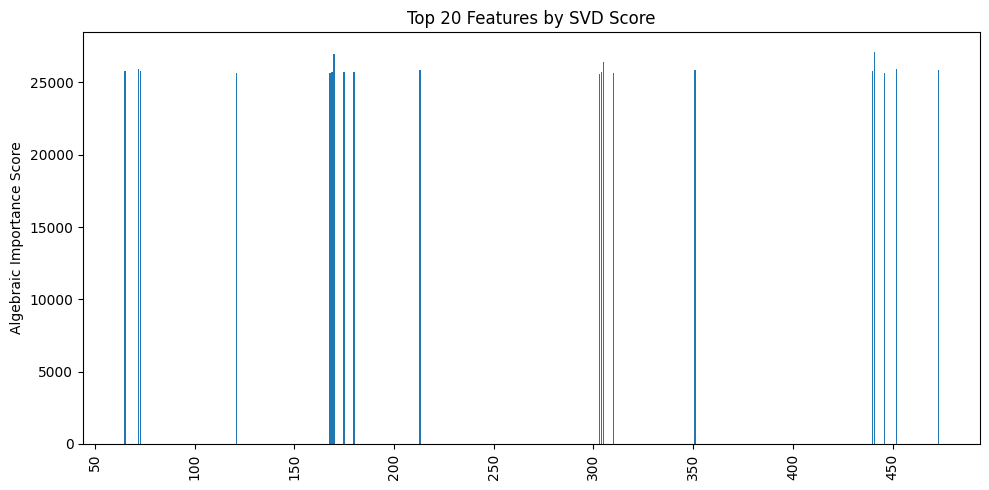

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assumptions:
# 'df_normalized' exists from Part One.
# We convert it to a numpy array for linear algebra operations.
X_mat = df_normalized.values
feature_names = df_normalized.columns

# --- Stage 1.3: Decomposition ---
print("Computing SVD (this may take a moment)...")

# full_matrices=False is more efficient (Economy SVD)
# U: Left singular vectors
# s: Singular values (Sigma) - 1D array in numpy
# Vt: Right singular vectors (V transposed)
U, s, Vt = np.linalg.svd(X_mat, full_matrices=False)

print(f"SVD Shapes -> U: {U.shape}, s: {s.shape}, Vt: {Vt.shape}")


# --- Stage 2.3: Mathematical Analysis (Scoring) ---

# 1. Determine k (How many singular vectors to use?)
# We generally want enough vectors to explain most of the variance (e.g., 90-95%)
# Calculation of Explained Variance Ratio
variance_explained = np.cumsum(s**2) / np.sum(s**2)
k = np.argmax(variance_explained >= 0.95) + 1  # Index of first item >= 0.95

print(f"Selected k = {k} components (explaining 95% of variance).")

# 2. Implement the Scoring Formula
# Score_j = sum( (sigma_i^2) * |V_ij| ) for i in 0..k
#
# Optimized Vectorized Implementation:
# We take the top k singular values and square them (s_k_squared)
# We take the top k rows of Vt and absolute them (Vt_k_abs)
# We perform a dot product to sum them efficiently.

s_k_squared = s[:k] ** 2
Vt_k_abs = np.abs(Vt[:k, :])

# Calculate scores for all features at once
# Shape: (k,) dot (k, n_features) -> (n_features,)
scores = np.dot(s_k_squared, Vt_k_abs)


# --- Stage 3.3: Selection ---

# Create a DataFrame to handle the sorting easily
scores_df = pd.DataFrame({
    'Feature': feature_names,
    'Score': scores
})

# Sort descending (High score = High importance)
top_features_df = scores_df.sort_values(by='Score', ascending=False).head(20)

print("\nTop 20 Features (Algebraic SVD Method):")
print(top_features_df['Feature'].tolist())

# Optional: Visualize the scores
plt.figure(figsize=(10, 5))
plt.bar(top_features_df['Feature'], top_features_df['Score'])
plt.xticks(rotation=90)
plt.title("Top 20 Features by SVD Score")
plt.ylabel("Algebraic Importance Score")
plt.tight_layout()
plt.show()

# Part 4


--- 1. Final Comparison Table ---
                 Method Accuracy F1-Score Selection Time
0  Mutual Info (Filter)   0.6146   0.7041           < 1s
1         RFE (Wrapper)   0.7261   0.7874        164.54s
2       SVD (Algebraic)   0.6146   0.7045           ~ 1s


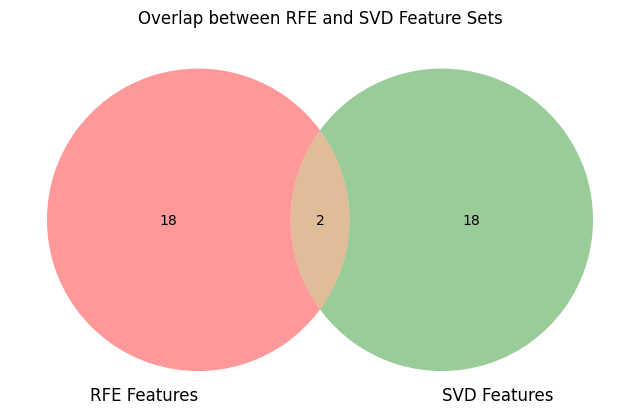


--- 2. Overlap Analysis ---
RFE Features: 20
SVD Features: 20
Overlapping Features: 2
Overlap Percentage: 10.0%


In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# --- 1. Model Training & Comparison ---

def evaluate_feature_set(X_data, y_data, features, method_name, exec_time_str):
    """
    Trains a logistic regression model on a specific subset of features
    and returns performance metrics.
    """
    # 1. Subset the data to only the selected features
    X_subset = X_data[features]

    # 2. Split data (80% train, 20% test)
    # random_state ensures reproducible results
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y_data, test_size=0.2, random_state=42)

    # 3. Train Logistic Regression
    # 'class_weight="balanced"' is useful for SECOM because Pass/Fail is unbalanced
    clf = LogisticRegression(max_iter=1000, solver='lbfgs', class_weight='balanced')
    clf.fit(X_train, y_train)

    # 4. Predict
    y_pred = clf.predict(X_test)

    # 5. Metrics
    acc = accuracy_score(y_test, y_pred)
    # Weighted F1 is better for imbalanced datasets than simple accuracy
    f1 = f1_score(y_test, y_pred, average='weighted')

    return {
        'Method': method_name,
        'Accuracy': f"{acc:.4f}",
        'F1-Score': f"{f1:.4f}",
        'Selection Time': exec_time_str
    }

# Prepare the lists of features
# SVD list needs to be extracted from the DataFrame created in Part 3
selected_features_svd = top_features_df['Feature'].tolist()

# Run evaluations
results = []

# Note: Replace 'execution_time' with the actual variable from Part 2 if available
# MI is instant, SVD is very fast, RFE is the slowest.
results.append(evaluate_feature_set(df_normalized, y, selected_features_mi, "Mutual Info (Filter)", "< 1s"))
results.append(evaluate_feature_set(df_normalized, y, selected_features_rfe, "RFE (Wrapper)", f"{execution_time:.2f}s"))
results.append(evaluate_feature_set(df_normalized, y, selected_features_svd, "SVD (Algebraic)", "~ 1s"))

# Create Comparison Table
results_df = pd.DataFrame(results)

print("\n--- 1. Final Comparison Table ---")
print(results_df)


# --- 2. Overlap Analysis (Venn Diagram) ---

plt.figure(figsize=(8, 6))

# Convert lists to sets for Venn diagram
set_rfe = set(selected_features_rfe)
set_svd = set(selected_features_svd)

# Draw Venn Diagram
# Note: If this fails, install library via: !pip install matplotlib-venn
try:
    venn2([set_rfe, set_svd], set_labels=('RFE Features', 'SVD Features'))
    plt.title("Overlap between RFE and SVD Feature Sets")
    plt.show()
except ImportError:
    print("\n(matplotlib-venn library not installed, skipping diagram)")

# Calculate exact overlap stats
overlap_count = len(set_rfe.intersection(set_svd))
total_features = 20
overlap_pct = (overlap_count / total_features) * 100

print(f"\n--- 2. Overlap Analysis ---")
print(f"RFE Features: {len(set_rfe)}")
print(f"SVD Features: {len(set_svd)}")
print(f"Overlapping Features: {overlap_count}")
print(f"Overlap Percentage: {overlap_pct}%")